In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import missingno as msno
from sklearn import metrics
from sklearn.model_selection import KFold

In [2]:
dataFrame = pd.read_excel("trainDataset.xls")
dataFrame.drop("ID", axis=1 ,inplace=True)
dataFrame.head()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0.0,0.0,1.0,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1.0,0.0,0.0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0.0,0.0,1.0,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0.0,0.0,1.0,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0.0,0.0,0.0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


We dont need to convert our data type

In [3]:

dataFrame['pCR (outcome)'].value_counts()

0      299
1       96
999      5
Name: pCR (outcome), dtype: int64

In [4]:
from scipy import stats
categoricalTitles = ['pCR (outcome)','ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage']
for c in dataFrame.columns:
    if c in categoricalTitles:
        continue
    q1Pos = 0.1
    q3Pos = 0.9
    q1=dataFrame[c].quantile(q1Pos)
    q3=dataFrame[c].quantile(q3Pos)
    IQR=q3-q1
    upper_limit = q3+1.5*IQR
    lower_limit = q1-1.5*IQR
    outliers = dataFrame[c][((dataFrame[c]<(q1-1.5*IQR)) | (dataFrame[c]>(q3+1.5*IQR)))]
    
    dataFrame[c] = dataFrame[c].apply(lambda x : np.where(x > upper_limit, np.nan, np.where(x < lower_limit, np.nan, x)))

In [5]:
dataFrame = dataFrame.replace(999, np.nan)
print("Nones: ",dataFrame.isnull().sum().sum())

Nones:  434


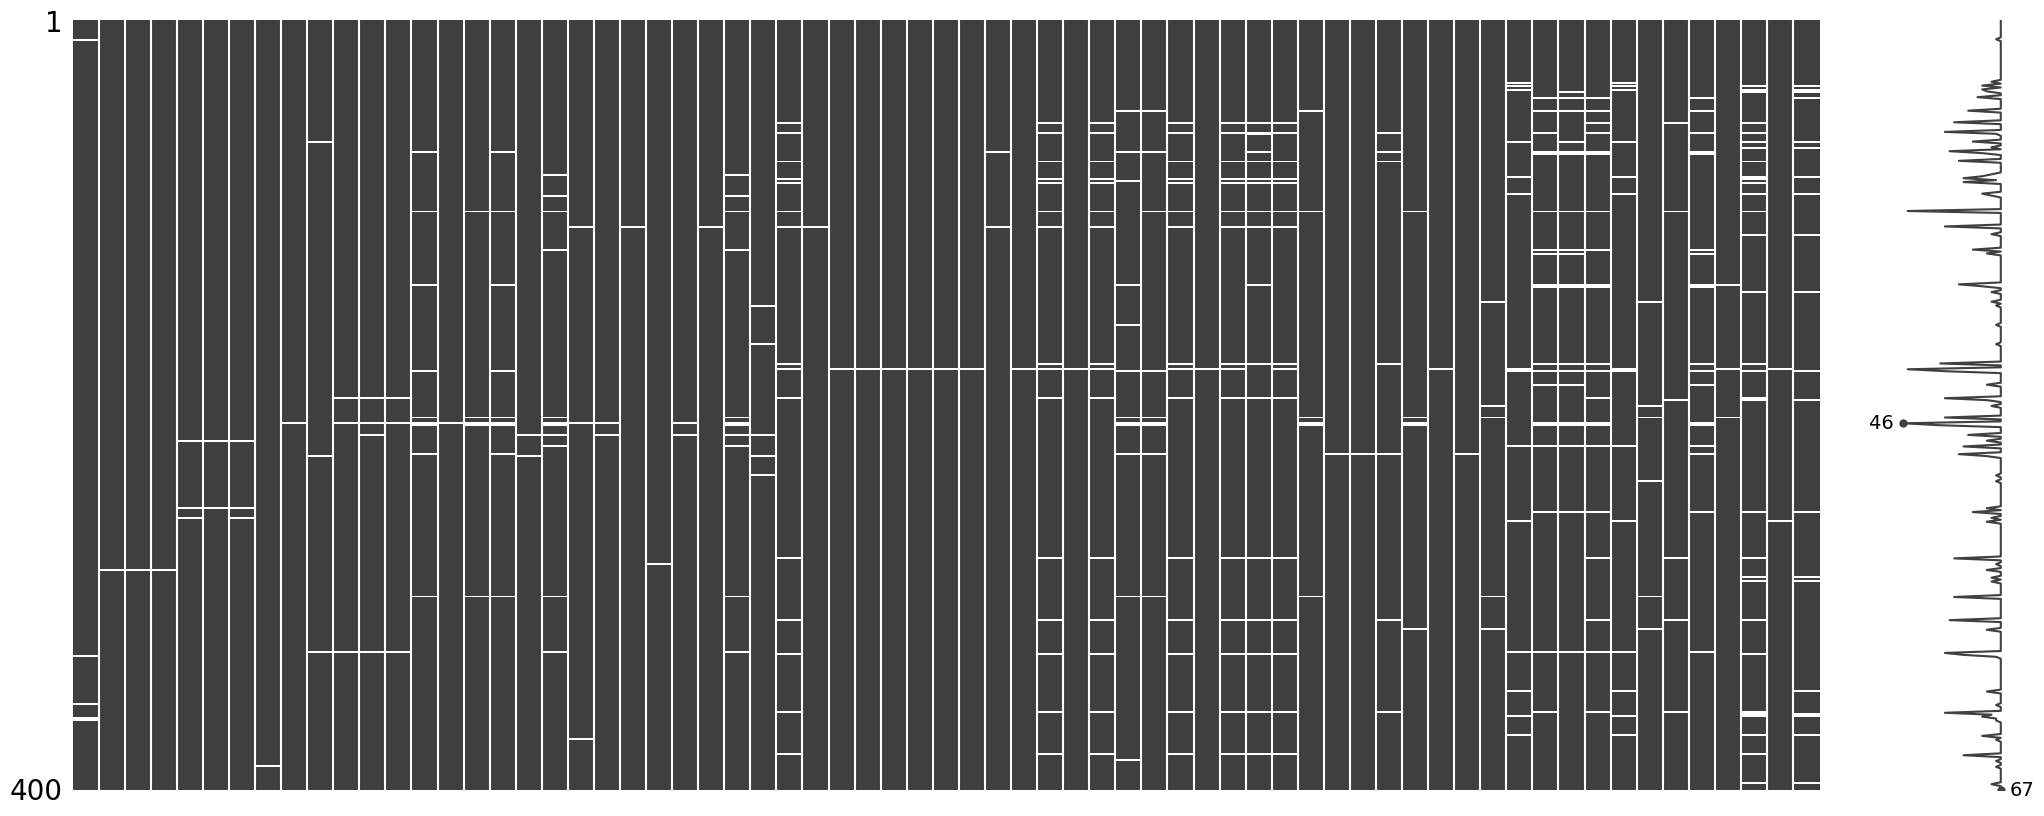

In [6]:
null_cols = dataFrame.columns[dataFrame.isnull().any()]
msno.matrix(dataFrame[null_cols])#white is missing data

<h1>KNN for missing value replacement</h1>

In [7]:
#knn imputer

from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
model = RandomForestClassifier(ccp_alpha= 0.014, random_state = 23, n_estimators = 441, min_samples_split = 8, max_features = 'log2', max_depth = 20, criterion = 'entropy')
bestNum = count = bestScore = 0
while count < 30:
    temp = random.randint(3, 65)
    imputer = KNNImputer(n_neighbors=temp)

    result = imputer.fit_transform(dataFrame)
    nonNulldataFrame = pd.DataFrame(result, columns= dataFrame.columns)#non null whole data set
    nonNulldataFrameBackUp = nonNulldataFrame
    categoricalTitles = ['pCR (outcome)','ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage']
    nonNulldataFrame = nonNulldataFrame[categoricalTitles].apply(lambda x: round(x))#for all categorical data, do round function
    nonNulldataFrameBackUp = nonNulldataFrameBackUp.drop(categoricalTitles, axis=1)
    nonNulldataFrame = pd.concat([nonNulldataFrame, nonNulldataFrameBackUp], axis=1)
    #checking for missing
    #print(nonNulldataFrame.isnull().sum().sum())
    
    
    #normalize Xs of non null data frame
    standardScaler = preprocessing.StandardScaler()
    normalizedXs = standardScaler.fit_transform(
    nonNulldataFrame.drop(["pCR (outcome)","RelapseFreeSurvival (outcome)"], axis=1))
    Xs_train, Xs_test, y_train, y_test = train_test_split(
        normalizedXs, 
        nonNulldataFrame["pCR (outcome)"], 
        test_size=0.2,
        random_state=1, 
        stratify=nonNulldataFrame["pCR (outcome)"])
    model.fit(Xs_train, y_train)
    score = metrics.accuracy_score(y_test, model.predict(Xs_test))
    if score > bestScore:
        bestScore = score
        bestNum = temp
    count = count + 1

#'shrinking': False, 'random_state': 18, 'kernel': 'rbf', 'gamma': 1000.0, 'degree': 36, 'C': 10000000.0

In [8]:
bestModelOverAll = None
performance = 0
isKeras = False

In [9]:
print(bestNum)
print(bestScore)

24
0.7875


In [10]:
imputer = KNNImputer(n_neighbors=bestNum)

result = imputer.fit_transform(dataFrame)
nonNulldataFrame = pd.DataFrame(result, columns= dataFrame.columns)#non null whole data set
nonNulldataFrameBackUp = nonNulldataFrame
categoricalTitles = ['pCR (outcome)','ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage']
nonNulldataFrame = nonNulldataFrame[categoricalTitles].apply(lambda x: round(x))#for all categorical data, do round function
nonNulldataFrameBackUp = nonNulldataFrameBackUp.drop(categoricalTitles, axis=1)
nonNulldataFrame = pd.concat([nonNulldataFrame, nonNulldataFrameBackUp], axis=1)
#checking for missing
print(nonNulldataFrame.isnull().sum().sum())
    
    

0


In [11]:
from sklearn import preprocessing
#normalize Xs of non null data frame
standardScaler = preprocessing.StandardScaler()
normalizedXs = standardScaler.fit_transform(
    nonNulldataFrame.drop(["pCR (outcome)","RelapseFreeSurvival (outcome)"], axis=1).values)

In [12]:
#bestFeatureSelectionModel = ReliefF(n_features_to_select=75, n_neighbors=87, n_jobs= -1)
#XsAfterFeatureSelection = bestFeatureSelectionModel.fit_transform(
#            normalizedXs,
#            np.array(nonNulldataFrame["pCR (outcome)"]))
#Xs_train, Xs_test, y_train, y_test = train_test_split(
#        XsAfterFeatureSelection, 
#        nonNulldataFrame["pCR (outcome)"], 
#        test_size=0.2,
#        random_state=1, 
#        stratify=nonNulldataFrame["pCR (outcome)"])
#model = models[1]
#model.fit(Xs_train, y_train)
#print("after fit")
    
#score = metrics.accuracy_score(y_test, model.predict(Xs_test))
#print(score)

In [13]:

from skrebate import ReliefF
import random
from sklearn.svm import LinearSVC,SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from PyImpetus import PPIMBC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

np.warnings.filterwarnings('ignore')
models = [SVC(shrinking = True, random_state = 31, kernel = 'rbf', gamma = 0.01, degree = 25, C = 0.1),
          RandomForestClassifier(ccp_alpha= 0.014, random_state = 23, n_estimators = 441, min_samples_split = 8, max_features = 'log2', max_depth = 20, criterion = 'entropy'),
          MLPClassifier(max_iter= 2000,  solver = 'sgd',  random_state = 15, learning_rate = 'constant', hidden_layer_sizes = (65, 29), alpha = 0.1, activation = 'tanh')]  
bestFeatureNum = bestneighborNum =  count = 0
bestScore = 0
bestFeatureSelectionModel = None
finalType = 0
while count < 20 :
    type = random.randint(0,2)
    if type < 2:
        featureNum = random.randint(10,90)
        neighborNum = random.randint(10,90)
        if type == 0:
            featureSelectionModel = ReliefF(n_features_to_select=featureNum, n_neighbors=neighborNum, n_jobs= -1)
        else:
            featureSelectionModel = PPIMBC(LogisticRegression(random_state=27, max_iter=1000, class_weight="balanced"), cv=0, num_simul=20, simul_type=0,simul_size=0.2, sig_test_type="non-parametric", random_state=27, verbose=0, p_val_thresh=0.05)
                            
        XsAfterFeatureSelection = featureSelectionModel.fit_transform(
            normalizedXs,
            np.array(nonNulldataFrame["pCR (outcome)"]))
    else:
        
        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(normalizedXs, np.array(nonNulldataFrame["pCR (outcome)"]))
        featureSelectionModel = SelectFromModel(lsvc, prefit=True)
        XsAfterFeatureSelection = featureSelectionModel.transform(normalizedXs)

    #split data up
    
    Xs_train, Xs_test, y_train, y_test = train_test_split(
        XsAfterFeatureSelection, 
        nonNulldataFrame["pCR (outcome)"], 
        test_size=0.2,
        random_state=1, 
        stratify=nonNulldataFrame["pCR (outcome)"])
    
    #print("before fit")
    model = models[random.randint(0,2)]
    model.fit(Xs_train, y_train)
    #print("after fit")
    
    score = metrics.accuracy_score(y_test, model.predict(Xs_test))
    
    if score > bestScore :
        count = 0
        bestScore = score
        bestFeatureSelectionModel  = featureSelectionModel
        finalType = type
    print("%d %s: %.2f%%" % (count ,"th Try", bestScore*100))
    if bestScore >= 0.8:
        count = count + 1

print("%s: %.2f%%" % ("Accuracy with Best Features", bestScore*100))


#after feature selection split the data
if finalType < 2:
    XsAfterFeatureSelection = bestFeatureSelectionModel.fit_transform(
            normalizedXs,
            np.array(nonNulldataFrame["pCR (outcome)"]))
else:
    XsAfterFeatureSelection = bestFeatureSelectionModel.transform(normalizedXs)
Xs_train, Xs_test, y_train, y_test = train_test_split(
        XsAfterFeatureSelection, 
        nonNulldataFrame["pCR (outcome)"], 
        test_size=0.2,
        random_state=1, 
        stratify=nonNulldataFrame["pCR (outcome)"])


0 th Try: 78.75%
0 th Try: 78.75%
0 th Try: 81.25%
1 th Try: 81.25%
2 th Try: 81.25%
3 th Try: 81.25%
4 th Try: 81.25%
5 th Try: 81.25%
6 th Try: 81.25%
7 th Try: 81.25%
8 th Try: 81.25%
9 th Try: 81.25%
10 th Try: 81.25%
11 th Try: 81.25%
12 th Try: 81.25%
13 th Try: 81.25%
14 th Try: 81.25%
15 th Try: 81.25%
16 th Try: 81.25%
17 th Try: 81.25%
18 th Try: 81.25%
19 th Try: 81.25%
Accuracy with Best Features: 81.25%


In [14]:
if finalType == 1:
    importantFeatures = bestFeatureSelectionModel.MB
    for i in range(len(importantFeatures)):
        importantFeatures[i] = importantFeatures[i].replace('Column','')
    for i in range(len(importantFeatures)):
        importantFeatures[i] = int(importantFeatures[i])
    df = nonNulldataFrame.drop(["pCR (outcome)","RelapseFreeSurvival (outcome)"], axis=1)
    names = []
    for i in range(len(importantFeatures)):
        names.append(df.columns[importantFeatures[i]])
    print(names)

In [15]:
if finalType == 0:
    class_data = dataFrame.drop(["pCR (outcome)","RelapseFreeSurvival (outcome)"], axis=1).columns.values
    dicti = dict(zip(class_data,bestFeatureSelectionModel.feature_importances_))
    important_feat = sorted(dicti.items(),key = lambda x:x[1],reverse = True)
    print(important_feat)
    names = []
    for i in range(len(Xs_train[0])):
        names.append(important_feat[i][0])

[('PgR', 0.16426829268292695), ('Age', 0.13048780487804887), ('ER', 0.11969512195121959), ('ChemoGrade', 0.09908536585365861), ('HistologyType', 0.09567073170731714), ('HER2', 0.07951219512195128), ('TrippleNegative', 0.07951219512195128), ('LNStatus', 0.07402439024390249), ('original_glcm_JointEnergy', 0.06214515405049756), ('original_glcm_JointEntropy', 0.061067857141104055), ('original_gldm_GrayLevelVariance', 0.060727239267103404), ('original_firstorder_Uniformity', 0.060727239229258906), ('original_glcm_SumEntropy', 0.05936436702734414), ('original_glcm_SumSquares', 0.05859417430939015), ('original_firstorder_Entropy', 0.057576657894910316), ('original_glcm_DifferenceVariance', 0.05504132601333934), ('original_glcm_ClusterProminence', 0.05487378928471993), ('original_glrlm_RunPercentage', 0.05434039730092), ('original_ngtdm_Complexity', 0.054055533438390375), ('original_glcm_MaximumProbability', 0.05377694409213456), ('original_glcm_ClusterTendency', 0.05370798783462379), ('origin

In [16]:
if finalType == 2:
    df = nonNulldataFrame.drop(["pCR (outcome)","RelapseFreeSurvival (outcome)"], axis=1)
    names = []
    importantFeatures = bestFeatureSelectionModel.get_support(indices=True)
    for i in range(len(importantFeatures)):
        names.append(df.columns[importantFeatures[i]])
    print(names)

In [17]:
print("%s: %d"  % ("best feature num",len(Xs_train[0])))
bestFeatureNum =len(Xs_train[0])
print(bestFeatureSelectionModel.get_params)
print(finalType)

best feature num: 71
<bound method BaseEstimator.get_params of ReliefF(n_features_to_select=71, n_jobs=-1, n_neighbors=41)>
0


In [18]:

np.warnings.filterwarnings('ignore')



from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import random


bestScore = 0
bestModel = None
outerLoop = KFold(n_splits=5)
innerLoop = KFold(n_splits=5)

outerK = 0
for i in range(2):
    for outter_train_index, outter_test_index in outerLoop.split(Xs_train):

        print("outer K: ",(outerK+1))
        outerK += 1
        X_total_train, X_total_test = np.array(Xs_train)[outter_train_index], np.array(Xs_train)[outter_test_index]
        y_total_train, y_total_test = np.array(y_train)[outter_train_index], np.array(y_train)[outter_test_index]
        innerBestScore = 0
        potentialBestModel = None
        innerK = 0
        for inner_train_index, inner_validation_index in innerLoop.split(X_total_train):
            print("innerK: ",(innerK+1))
            X_inner_train, X_validation = np.array(X_total_train)[inner_train_index], np.array(X_total_train)[inner_validation_index]
            y_inner_train, y_validation = np.array(y_total_train)[inner_train_index], np.array(y_total_train)[inner_validation_index]

            param_mlpc = {   
                            'hidden_layer_sizes' : [(random.randint(100,150),random.randint(50, 70),random.randint(10, 30)),
                                                    (random.randint(50,70),random.randint(10,30)),
                                                    (random.randint(10, 30))],
                            'activation' : ['identity','logistic','tanh','relu'],
                            "random_state" : range(0, 50),
                            'alpha' : [0.0001, 0.001, 0.01, 0.1],
                            'solver' : ['sgd','adam'],
                            'learning_rate' : ['constant','invscaling'],
                            
                            }
            #find the best parameter tunning
            #to be implemented

            grid = RandomizedSearchCV(MLPClassifier(max_iter= 500),param_mlpc,refit=True,verbose=1,n_iter= 10)
            model = grid.fit(X_inner_train, y_inner_train)
            model.predict(X_validation)
            innerScore = metrics.accuracy_score(y_validation, model.predict(X_validation))
            print(" %s: %.2f%%" % ("Classification accuracy", innerScore * 100))
            if(innerScore > innerBestScore):
                innerBestScore = innerScore
                potentialBestModel = model
            innerK += 1

        #fit the model using the best parameter
        y_pred = potentialBestModel.predict(X_total_test)
        score = metrics.accuracy_score(y_total_test, y_pred)

        #keep a reference of the best model for further usage
        if(score > bestScore):
            #print(bestModel.best_params_)
            bestScore = score
            bestModel = potentialBestModel

testResult = bestModel.predict(Xs_test)
print("%s: %.2f%%" % ("Best Model Classification accuracy", (metrics.accuracy_score(y_test, testResult))*100))
print(bestModel.best_params_)
if (metrics.accuracy_score(y_test, testResult)) > performance:
    performance = metrics.accuracy_score(y_test, testResult)
    bestModelOverAll = bestModel
    isKeras = False

outer K:  1
innerK:  1
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 75.00%
innerK:  2
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 78.43%
innerK:  3
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 74.51%
innerK:  4
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 72.55%
innerK:  5
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 76.47%
outer K:  2
innerK:  1
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 76.92%
innerK:  2
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 78.43%
innerK:  3
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 76.47%
innerK:  4
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Classification accuracy: 72.55%
innerK:  5
Fitting 5 folds for each of 5

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import random
import tensorflow as tf
from tensorflow import keras


bestScore = 0
outerLoop = KFold(n_splits=5)
innerLoop = KFold(n_splits=5)

outerK = 0
for i in range(3):
    for outter_train_index, outter_test_index in outerLoop.split(Xs_train):

        print("outer K: ",(outerK+1))
        outerK += 1
        X_total_train, X_total_test = np.array(Xs_train)[outter_train_index], np.array(Xs_train)[outter_test_index]
        y_total_train, y_total_test = np.array(y_train)[outter_train_index], np.array(y_train)[outter_test_index]
        
        activationTypes = ['relu', 'sigmoid', 'softmax','softplus','softsign','tanh','selu','elu','exponential']

        ann=keras.models.Sequential()
        ann.add(keras.layers.Dense(random.randint(100,150), input_dim=bestFeatureNum,activation=activationTypes[random.randint(0,8)]))
        ann.add(keras.layers.Dense(random.randint(30,60),activation=activationTypes[random.randint(0,8)]))
        ann.add(keras.layers.Dense(random.randint(5,15),activation=activationTypes[random.randint(0,8)]))
        ann.add(keras.layers.Dense(1,activation=activationTypes[random.randint(0,8)]))

        lossTypes = ['binary_crossentropy', 'hinge']
        optimizerType = ['sgd', 'adam']
        ann.compile(loss=lossTypes[random.randint(0,1)], optimizer=optimizerType[random.randint(0,1)], metrics=["accuracy"])
        # save the initial weight for initilise new models in cross validation
        ann.save_weights('model.h5')

        innerK = 0
        for inner_train_index, inner_validation_index in innerLoop.split(X_total_train):
            print("innerK: ",(innerK+1))
            X_inner_train, X_validation = np.array(X_total_train)[inner_train_index], np.array(X_total_train)[inner_validation_index]
            y_inner_train, y_validation = np.array(y_total_train)[inner_train_index], np.array(y_total_train)[inner_validation_index]
            ann.load_weights('model.h5')
            model = ann.fit(np.array(X_inner_train),
                            np.array(y_inner_train), 
                            epochs = 500, 
                            validation_data=(np.array(X_validation),np.array(y_validation)),
                            verbose= 0)
            scores = ann.evaluate(np.array(X_total_test),np.array(y_total_test), verbose=0)
            #keep a reference of the best model for further usage
            if(scores[1] > bestScore):
                #print(bestModel.best_params_)
                bestScore = scores[1]
                ann.save('best.h5')
            innerK += 1

testResults = keras.models.load_model('best.h5').evaluate(np.array(Xs_test),np.array(y_test), verbose=0)
print("%s: %.2f%%" % ("Best Model Classification accuracy", testResults[1]*100))

if (metrics.accuracy_score(y_test, testResult)) > performance:
    performance = metrics.accuracy_score(y_test, testResult)
    bestModelOverAll = keras.models.load_model('best.h5')
    isKeras = True

outer K:  1
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  2
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  3
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  4
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  5
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  6
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  7
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  8
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  9
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  10
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  11
innerK:  1
innerK:  2
innerK:  3
innerK:  4
innerK:  5
outer K:  12
innerK:  1
innerK:  2
innerK:  3
inn

In [20]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import random


bestScore = 0
bestModel = None
outerLoop = KFold(n_splits=5)
innerLoop = KFold(n_splits=5)

outerK = 0
for i in range(3):
    for outter_train_index, outter_test_index in outerLoop.split(Xs_train):

        print("outer K: ",(outerK+1))
        outerK += 1
        X_total_train, X_total_test = np.array(Xs_train)[outter_train_index], np.array(Xs_train)[outter_test_index]
        y_total_train, y_total_test = np.array(y_train)[outter_train_index], np.array(y_train)[outter_test_index]
        innerBestScore = 0
        potentialBestModel = None
        innerK = 0
        for inner_train_index, inner_validation_index in innerLoop.split(X_total_train):
            print("innerK: ",(innerK+1))
            X_inner_train, X_validation = np.array(X_total_train)[inner_train_index], np.array(X_total_train)[inner_validation_index]
            y_inner_train, y_validation = np.array(y_total_train)[inner_train_index], np.array(y_total_train)[inner_validation_index]

            param_svc = {   'C': np.logspace(-2, 10, 13),
                            #'degree': range(10,50),
                            'gamma': np.logspace(-9, 3, 13),
                            'shrinking' : [True, False],
                            "random_state" : range(0, 50)
                            }
            #find the best parameter tunning
            #to be implemented

            grid = RandomizedSearchCV(SVC(),param_svc,refit=True,verbose=1,n_iter= 50)
            model = grid.fit(X_inner_train, y_inner_train)
            model.predict(X_validation)
            innerScore = metrics.accuracy_score(y_validation, model.predict(X_validation))
            print(" %s: %.2f%%" % ("Classification accuracy", innerScore * 100))
            if(innerScore > innerBestScore):
                innerBestScore = innerScore
                potentialBestModel = model
            innerK += 1

        #fit the model using the best parameter
        y_pred = potentialBestModel.predict(X_total_test)
        score = metrics.accuracy_score(y_total_test, y_pred)

        #keep a reference of the best model for further usage
        if(score > bestScore):
            #print(bestModel.best_params_)
            bestScore = score
            bestModel = potentialBestModel


testResult = bestModel.predict(Xs_test)
print("%s: %.2f%%" % ("Best Model Classification accuracy", (metrics.accuracy_score(y_test, testResult))*100))
print(bestModel.best_params_)
if (metrics.accuracy_score(y_test, testResult)) > performance:
    performance = metrics.accuracy_score(y_test, testResult)
    bestModelOverAll = bestModel
    isKeras = False

outer K:  1
innerK:  1
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 67.31%
innerK:  2
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 74.51%
innerK:  3
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 74.51%
innerK:  4
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 72.55%
innerK:  5
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 76.47%
outer K:  2
innerK:  1
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 75.00%
innerK:  2
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 78.43%
innerK:  3
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 74.51%
innerK:  4
Fitting 5 folds for each of 50 candidates, totalling 250 fits
 Classification accuracy: 74.51%
innerK:  5
Fitting 5 f

Decision tree

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import random


bestScore = 0
bestModel = None
outerLoop = KFold(n_splits=5)
innerLoop = KFold(n_splits=5)

outerK = 0
for i in range(5):
    for outter_train_index, outter_test_index in outerLoop.split(Xs_train):

        print("outer K: ",(outerK+1))
        outerK += 1
        X_total_train, X_total_test = np.array(Xs_train)[outter_train_index], np.array(Xs_train)[outter_test_index]
        y_total_train, y_total_test = np.array(y_train)[outter_train_index], np.array(y_train)[outter_test_index]
        innerBestScore = 0
        potentialBestModel = None
        innerK = 0
        for inner_train_index, inner_validation_index in innerLoop.split(X_total_train):
            print("innerK: ",(innerK+1))
            X_inner_train, X_validation = np.array(X_total_train)[inner_train_index], np.array(X_total_train)[inner_validation_index]
            y_inner_train, y_validation = np.array(y_total_train)[inner_train_index], np.array(y_total_train)[inner_validation_index]

            param_random_forest = {   "n_estimators" : range(100, 500),
                                    "criterion" : ["gini","entropy"],
                                    "max_depth" : range(3, 25),
                                    "min_samples_split" : range(2, 10),
                                    "max_features" : ["auto", "sqrt", "log2", None],
                                    "random_state" : range(0, 50),
                                    "warm_start" : [True, False]
                                    }
            #find the best parameter tunning
            #to be implemented

            grid = RandomizedSearchCV(RandomForestClassifier(ccp_alpha= random.uniform(0.012,0.019)),param_random_forest,refit=True,verbose=1,n_iter= 2)
            model = grid.fit(X_inner_train, y_inner_train)
            model.predict(X_validation)
            innerScore = metrics.accuracy_score(y_validation, model.predict(X_validation))
            print(" %s: %.2f%%" % ("Classification accuracy", innerScore * 100))
            if(innerScore > innerBestScore):
                innerBestScore = innerScore
                potentialBestModel = model
            innerK += 1

        #fit the model using the best parameter
        y_pred = potentialBestModel.predict(X_total_test)
        score = metrics.accuracy_score(y_total_test, y_pred)

        #keep a reference of the best model for further usage
        if(score > bestScore):
            bestScore = score
            bestModel = potentialBestModel


testResult = bestModel.predict(Xs_test)
print("%s: %.2f%%" % ("Best Model Classification accuracy", (metrics.accuracy_score(y_test, testResult))*100))
print(bestModel.best_params_)

if (metrics.accuracy_score(y_test, testResult)) > performance:
    performance = metrics.accuracy_score(y_test, testResult)
    bestModelOverAll = bestModel
    isKeras = False

outer K:  1
innerK:  1
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 65.38%
innerK:  2
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 78.43%
innerK:  3
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 74.51%
innerK:  4
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 72.55%
innerK:  5
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 74.51%
outer K:  2
innerK:  1
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 73.08%
innerK:  2
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 76.47%
innerK:  3
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 76.47%
innerK:  4
Fitting 5 folds for each of 2 candidates, totalling 10 fits
 Classification accuracy: 66.67%
innerK:  5
Fitting 5 folds for each of 2

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


bestScore = 0
bestModel = None
outerLoop = KFold(n_splits=5)
innerLoop = KFold(n_splits=5)

outerK = 0
for i in range(5):
    for outter_train_index, outter_test_index in outerLoop.split(Xs_train):

        print("outer K: ",(outerK+1))
        outerK += 1
        X_total_train, X_total_test = np.array(Xs_train)[outter_train_index], np.array(Xs_train)[outter_test_index]
        y_total_train, y_total_test = np.array(y_train)[outter_train_index], np.array(y_train)[outter_test_index]
        innerBestScore = 0
        potentialBestModel = None
        innerK = 0
        for inner_train_index, inner_validation_index in innerLoop.split(X_total_train):
            print("innerK: ",(innerK+1))
            X_inner_train, X_validation = np.array(X_total_train)[inner_train_index], np.array(X_total_train)[inner_validation_index]
            y_inner_train, y_validation = np.array(y_total_train)[inner_train_index], np.array(y_total_train)[inner_validation_index]

            param_dision_tree = {   "criterion" : ["gini","entropy"],
                                    "splitter" : ["best", "random"],
                                    "max_depth" : range(5,200),
                                    "max_features" : ["auto", "sqrt", "log2", None]}
            #find the best parameter tunning
            #to be implemented

            grid = RandomizedSearchCV(DecisionTreeClassifier(),param_dision_tree,refit=True,verbose=1,n_iter= 70)
            model = grid.fit(X_inner_train, y_inner_train)
            model.predict(X_validation)
            innerScore = metrics.accuracy_score(y_validation, model.predict(X_validation))
            print(" %s: %.2f%%" % ("Classification accuracy", innerScore * 100))
            if(innerScore > innerBestScore):
                innerBestScore = innerScore
                potentialBestModel = model
            innerK += 1

        #fit the model using the best parameter
        y_pred = potentialBestModel.predict(X_total_test)
        score = metrics.accuracy_score(y_total_test, y_pred)

        #keep a reference of the best model for further usage
        if(score > bestScore):
            bestScore = score
            bestModel = potentialBestModel


testResult = bestModel.predict(Xs_test)
print("%s: %.2f%%" % ("Best Model Classification accuracy", (metrics.accuracy_score(y_test, testResult))*100))
print(bestModel.best_params_)
if (metrics.accuracy_score(y_test, testResult)) > performance:
    performance = metrics.accuracy_score(y_test, testResult)
    bestModelOverAll = bestModel
    isKeras = False

outer K:  1
innerK:  1
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 57.69%
innerK:  2
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 66.67%
innerK:  3
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 70.59%
innerK:  4
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 54.90%
innerK:  5
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 62.75%
outer K:  2
innerK:  1
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 75.00%
innerK:  2
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 60.78%
innerK:  3
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 70.59%
innerK:  4
Fitting 5 folds for each of 70 candidates, totalling 350 fits
 Classification accuracy: 58.82%
innerK:  5
Fitting 5 f

In [ ]:
testFrame = pd.read_excel("testDatasetExample.xls")
testFrame.drop("ID", axis=1 ,inplace=True)
testFrame = testFrame[names]
scaledFeatures = standardScaler.fit_transform(testFrame.values)
scaledFeaturesDF = pd.DataFrame(scaledFeatures, columns=testFrame.columns)
scaledFeaturesDF.head()

trainFrame = nonNulldataFrame[names]
scaledTrainFeature = standardScaler.fit_transform(trainFrame.values)

In [ ]:
if isKeras == True:
    Y_PRED = bestModelOverAll.predict_classes(np.array(scaledFeatures), verbose=0)
    for i in range(len(Y_PRED)):
        print(Y_PRED[i])
else:
    Y_PRED = bestModelOverAll.predict(scaledFeatures)
    for i in range(len(Y_PRED)):
        print(Y_PRED[i])

In [ ]:
if isKeras == True:
    Y_PRED = bestModelOverAll.predict_classes(np.array(scaledFeatures), verbose=0)
    for i in range(len(Y_PRED)):
        print(Y_PRED[i])
else:
    bestModelOverAll.fit(scaledTrainFeature, nonNulldataFrame["pCR (outcome)"])
    Y_PRED = bestModelOverAll.predict(scaledFeatures)
    for i in range(len(Y_PRED)):
        print(Y_PRED[i])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.0
0.0
0.0


In [ ]:
if isKeras == True:
    Y_PRED = bestModelOverAll.predict_classes(np.array(scaledFeatures), verbose=0)
    for i in range(len(Y_PRED)):
        print(Y_PRED[i])
else:
    bestModelOverAll.fit(scaledTrainFeature, nonNulldataFrame["pCR (outcome)"].values)
    Y_PRED = bestModelOverAll.predict(scaledFeatures)
    for i in range(len(Y_PRED)):
        print(Y_PRED[i])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.0
0.0
0.0


In [ ]:
print(performance)

0.7625
